In [43]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import re
from tqdm import tqdm
from datetime import datetime
import dateutil.parser
import nltk
from spellchecker import SpellChecker
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import scattertext as st
from IPython.display import IFrame
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import random 
nltk.download('vader_lexicon')
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to C:\Users\Asus^.DESKTO
[nltk_data]     P-2BG56U4\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Asus^.DESKTOP-
[nltk_data]     2BG56U4\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
# Prepare the Dataset
df = pd.read_csv('reddit_opinion_PSE_ISR.csv')
df.head()

,comment_id,score,self_text,subreddit,created_time,post_id,author_name,controversiality,ups,downs,...,user_link_karma,user_comment_karma,user_total_karma,post_score,post_self_text,post_title,post_upvote_ratio,post_thumbs_ups,post_total_awards_received,post_created_time
0,kghrv5i,1,The right flight attendant for this shit. He i...,PublicFreakout,2024-01-05 21:38:50,18zg5pz,Smegmatikus,0,1,0,...,160.0,375.0,555.0,415,NaN,Karen refuses to get off a plane after strikin...,0.99,415,0,2024-01-05 20:07:10
1,kghru8l,1,There seems to be a general theme with these p...,PublicFreakout,2024-01-05 21:38:41,18zg5pz,Mystery_meander25,0,1,0,...,11640.0,21025.0,33079.0,415,NaN,Karen refuses to get off a plane after strikin...,0.99,415,0,2024-01-05 20:07:10
2,kghrs70,1,The big deal here is that taking something tha...,worldnewsvideo,2024-01-05 21:38:22,18zbxur,Capt_Easychord,0,1,0,...,17635.0,78673.0,97450.0,47,NaN,I have to wonder if political zionism could ev...,0.90,47,0,2024-01-05 17:11:56
3,kghrqwo,1,She didnt like the cut of his jib,PublicFreakout,2024-01-05 21:38:10,18zib35,Beginning-Anxiety703,0,1,0,...,197.0,3009.0,3391.0,1,NaN,UK TV host freaks out on Palestinian guest.,1.00,1,0,2024-01-05 21:35:53
4,kghrp57,1,&gt;It’s because the logical conclusion of you...,IsraelPalestine,2024-01-05 21:37:53,18zd7tu,LilyBelle504,0,1,0,...,32.0,2424.0,2456.0,5,Edit: __BIG /S HERE FOR ALL THE PEOPLE WITH TH...,Israel Never Killed Many Innocent Civilians,0.53,5,0,2024-01-05 18:04:47


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617636 entries, 0 to 617635
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   comment_id                  617636 non-null  object 
 1   score                       617636 non-null  int64  
 2   self_text                   617633 non-null  object 
 3   subreddit                   617636 non-null  object 
 4   created_time                617636 non-null  object 
 5   post_id                     617636 non-null  object 
 6   author_name                 617636 non-null  object 
 7   controversiality            617636 non-null  int64  
 8   ups                         617636 non-null  int64  
 9   downs                       617636 non-null  int64  
 10  user_is_verified            617636 non-null  bool   
 11  user_account_created_time   603153 non-null  object 
 12  user_awardee_karma          617574 non-null  float64
 13  user_awarder_k

In [46]:
#check missing value
df.isna().sum()

comment_id                         0
score                              0
self_text                          3
subreddit                          0
created_time                       0
post_id                            0
author_name                        0
controversiality                   0
ups                                0
downs                              0
user_is_verified                   0
user_account_created_time      14483
user_awardee_karma                62
user_awarder_karma                62
user_link_karma                   62
user_comment_karma                62
user_total_karma                  62
post_score                         0
post_self_text                324190
post_title                         0
post_upvote_ratio                  0
post_thumbs_ups                    0
post_total_awards_received         0
post_created_time                  0
dtype: int64

In [47]:
df.dropna(subset=['self_text'], inplace=True)

In [49]:
# Make the copy of dataframe
data = df.copy()
data['text'] = df['self_text']
data['datetime'] = data['created_time']
data['datetime'] = data.datetime.apply(lambda x: dateutil.parser.parse(x))

# Data preprocessing 
data.text = data.text.str.lower()
# Remove URLS
data.text = data.text.apply(lambda x:re.sub(r"http\S+", "", x))
# Remove handlers
data.text = data.text.apply(lambda x:re.sub('@[^\s]+','',x))
# Remove hashtags
data.text = data.text.apply(lambda x:re.sub(r'\B#\S+','',x))
# Remove single characters
data.text = data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
# Remove special characters
data.text = data.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))
# Change multiple spaces with single space
data.text = data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

# Convert 'datetime' column to datetime format and remove timezone information
data['datetime'] = pd.to_datetime(data['datetime']).dt.tz_localize(None)

# Viewing the preprocessed data
data.head()

,comment_id,score,self_text,subreddit,created_time,post_id,author_name,controversiality,ups,downs,...,user_total_karma,post_score,post_self_text,post_title,post_upvote_ratio,post_thumbs_ups,post_total_awards_received,post_created_time,text,datetime
0,kghrv5i,1,The right flight attendant for this shit. He i...,PublicFreakout,2024-01-05 21:38:50,18zg5pz,Smegmatikus,0,1,0,...,555.0,415,NaN,Karen refuses to get off a plane after strikin...,0.99,415,0,2024-01-05 20:07:10,the right flight attendant for this shit he is...,2024-01-05 21:38:50
1,kghru8l,1,There seems to be a general theme with these p...,PublicFreakout,2024-01-05 21:38:41,18zg5pz,Mystery_meander25,0,1,0,...,33079.0,415,NaN,Karen refuses to get off a plane after strikin...,0.99,415,0,2024-01-05 20:07:10,there seems to begeneral theme with these ppl ...,2024-01-05 21:38:41
2,kghrs70,1,The big deal here is that taking something tha...,worldnewsvideo,2024-01-05 21:38:22,18zbxur,Capt_Easychord,0,1,0,...,97450.0,47,NaN,I have to wonder if political zionism could ev...,0.90,47,0,2024-01-05 17:11:56,the big deal here is that taking something tha...,2024-01-05 21:38:22
3,kghrqwo,1,She didnt like the cut of his jib,PublicFreakout,2024-01-05 21:38:10,18zib35,Beginning-Anxiety703,0,1,0,...,3391.0,1,NaN,UK TV host freaks out on Palestinian guest.,1.00,1,0,2024-01-05 21:35:53,she didnt like the cut of his jib,2024-01-05 21:38:10
4,kghrp57,1,&gt;It’s because the logical conclusion of you...,IsraelPalestine,2024-01-05 21:37:53,18zd7tu,LilyBelle504,0,1,0,...,2456.0,5,Edit: __BIG /S HERE FOR ALL THE PEOPLE WITH TH...,Israel Never Killed Many Innocent Civilians,0.53,5,0,2024-01-05 18:04:47,gt it s because the logical conclusion of your...,2024-01-05 21:37:53


In [50]:
# For sentiment analysis 
sia = SIA() 

# To identify misspelled words
spell = SpellChecker() 

# Make label of sentiment
def label_sentiment(x:float):
    if x < -0.05 : return 'negative'
    if x > 0.35 : return 'positive'
    return 'neutral'

# Feature Extraction
data['words'] = data.text.apply(lambda x:re.findall(r'\w+', x ))
data['errors'] = data.words.apply(spell.unknown)
data['errors_count'] = data.errors.apply(len)
data['words_count'] = data.words.apply(len)
data['sentence_length'] = data.text.apply(len)
data['hour'] = data.datetime.apply(lambda x: x.hour)
data['date'] = data.datetime.apply(lambda x: x.date())
data['month'] = data.datetime.apply(lambda x: x.month)
data['year'] = data.datetime.apply(lambda x: x.year)


# Extract Sentiment Values for reddit opinion 
data['sentiment'] = [sia.polarity_scores(x)['compound'] for x in tqdm(data['text'])]
data['overall_sentiment'] = data['sentiment'].apply(label_sentiment);

Exception ignored in: <function tqdm.__del__ at 0x000001F153492020>
Traceback (most recent call last):
  File "C:\Users\Asus^.DESKTOP-2BG56U4\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\std.py", line 1149, in __del__
    self.close()
  File "C:\Users\Asus^.DESKTOP-2BG56U4\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
100%|████████████████████████████████████████████████████████████████████████| 617633/617633 [09:48<00:00, 1049.40it/s]


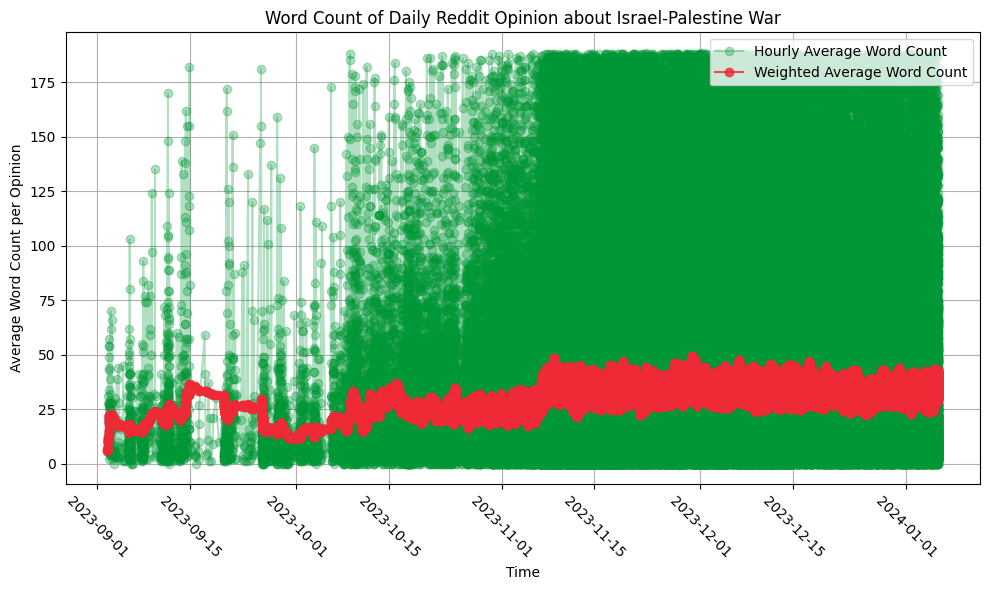

In [52]:
def weighted_avg(data, beta):
    return data.ewm(alpha=1-beta).mean()

# Set smoothing parameter
beta = 0.99

# Compute hourly average word count
avg_word_count = data.groupby('datetime')['words_count'].mean()
avg_word_count_std = avg_word_count.std()
avg_word_count = avg_word_count[avg_word_count < 3 * avg_word_count_std]

# Get weighted average
weighted_avg_word_count = weighted_avg(avg_word_count, beta)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(avg_word_count.index, avg_word_count.values, 'o-', label="Hourly Average Word Count", color="#009736", alpha=0.3)
plt.plot(weighted_avg_word_count.index, weighted_avg_word_count.values, 'o-', label="Weighted Average Word Count", color='#EE2A35', alpha=0.8)
plt.title("Word Count of Daily Reddit Opinion about Israel-Palestine War")
plt.xlabel("Time")
plt.ylabel("Average Word Count per Opinion")
plt.legend(loc='upper right')
plt.xticks(rotation=-45)
plt.grid(True)
plt.tight_layout()
plt.show()

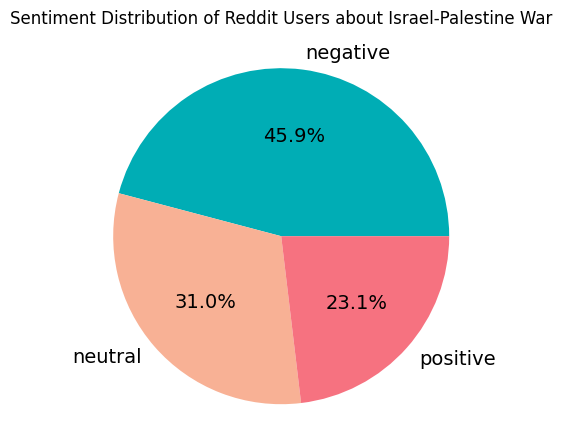

In [53]:
# Copy DataFrame with sentiment data
data_copy = data.copy()

# Calculate sentiment distribution percentages
sentiment_dist = pd.DataFrame(data_copy['overall_sentiment'].value_counts() / data_copy.shape[0]*100).reset_index()
sentiment_dist.columns = ['Sentiment', 'Percentage']

colors = ['#00adb5', '#f8b195', '#f67280']

# Plotting pie chart
plt.figure(dpi=100)
plt.pie(sentiment_dist['Percentage'], labels=sentiment_pie['Sentiment'], autopct='%1.1f%%', colors=colors, textprops={'fontsize': 14})
plt.title("Sentiment Distribution of Reddit Users about Israel-Palestine War", fontsize=12, pad=20)
plt.axis('equal')
plt.show()


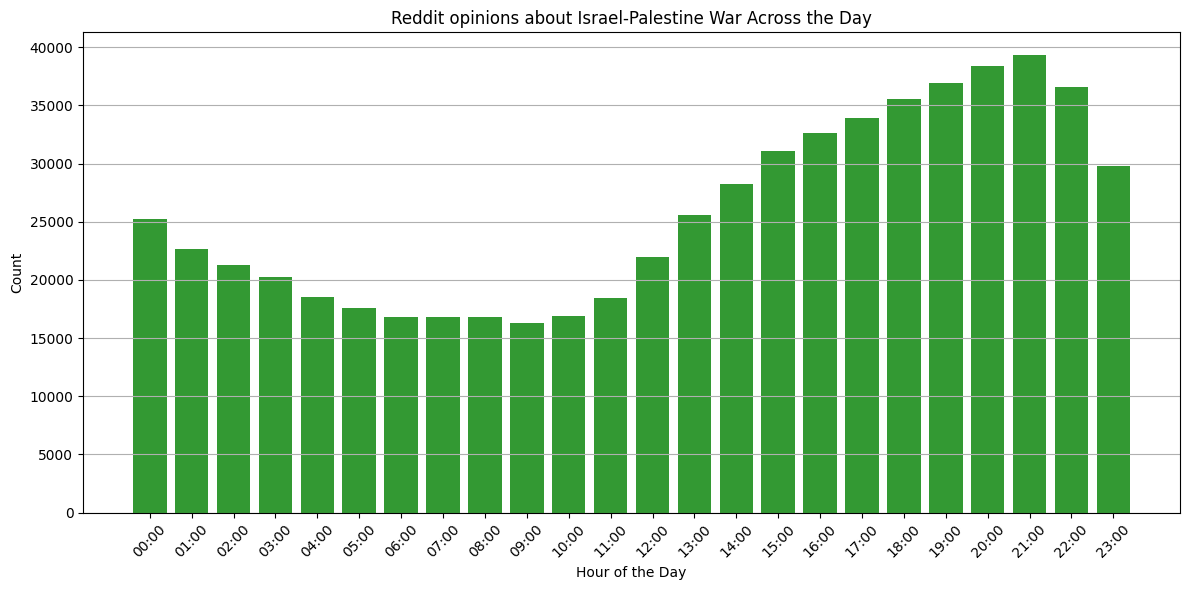

In [56]:
annual_counts = pd.DataFrame(data_copy['hour'].value_counts()).reset_index()
annual_counts.columns = ['hour', 'count']
annual_counts = annual_counts.sort_values('hour')

plt.figure(figsize=(12, 6))
plt.bar(annual_counts['hour'], annual_counts['count'], color="green", alpha=0.8)

# Customize the x-axis ticks
plt.xticks(np.arange(0, 24), [f"{h:02d}:00" for h in range(24)])

#Plotting
plt.title("Reddit opinions about Israel-Palestine War Across the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

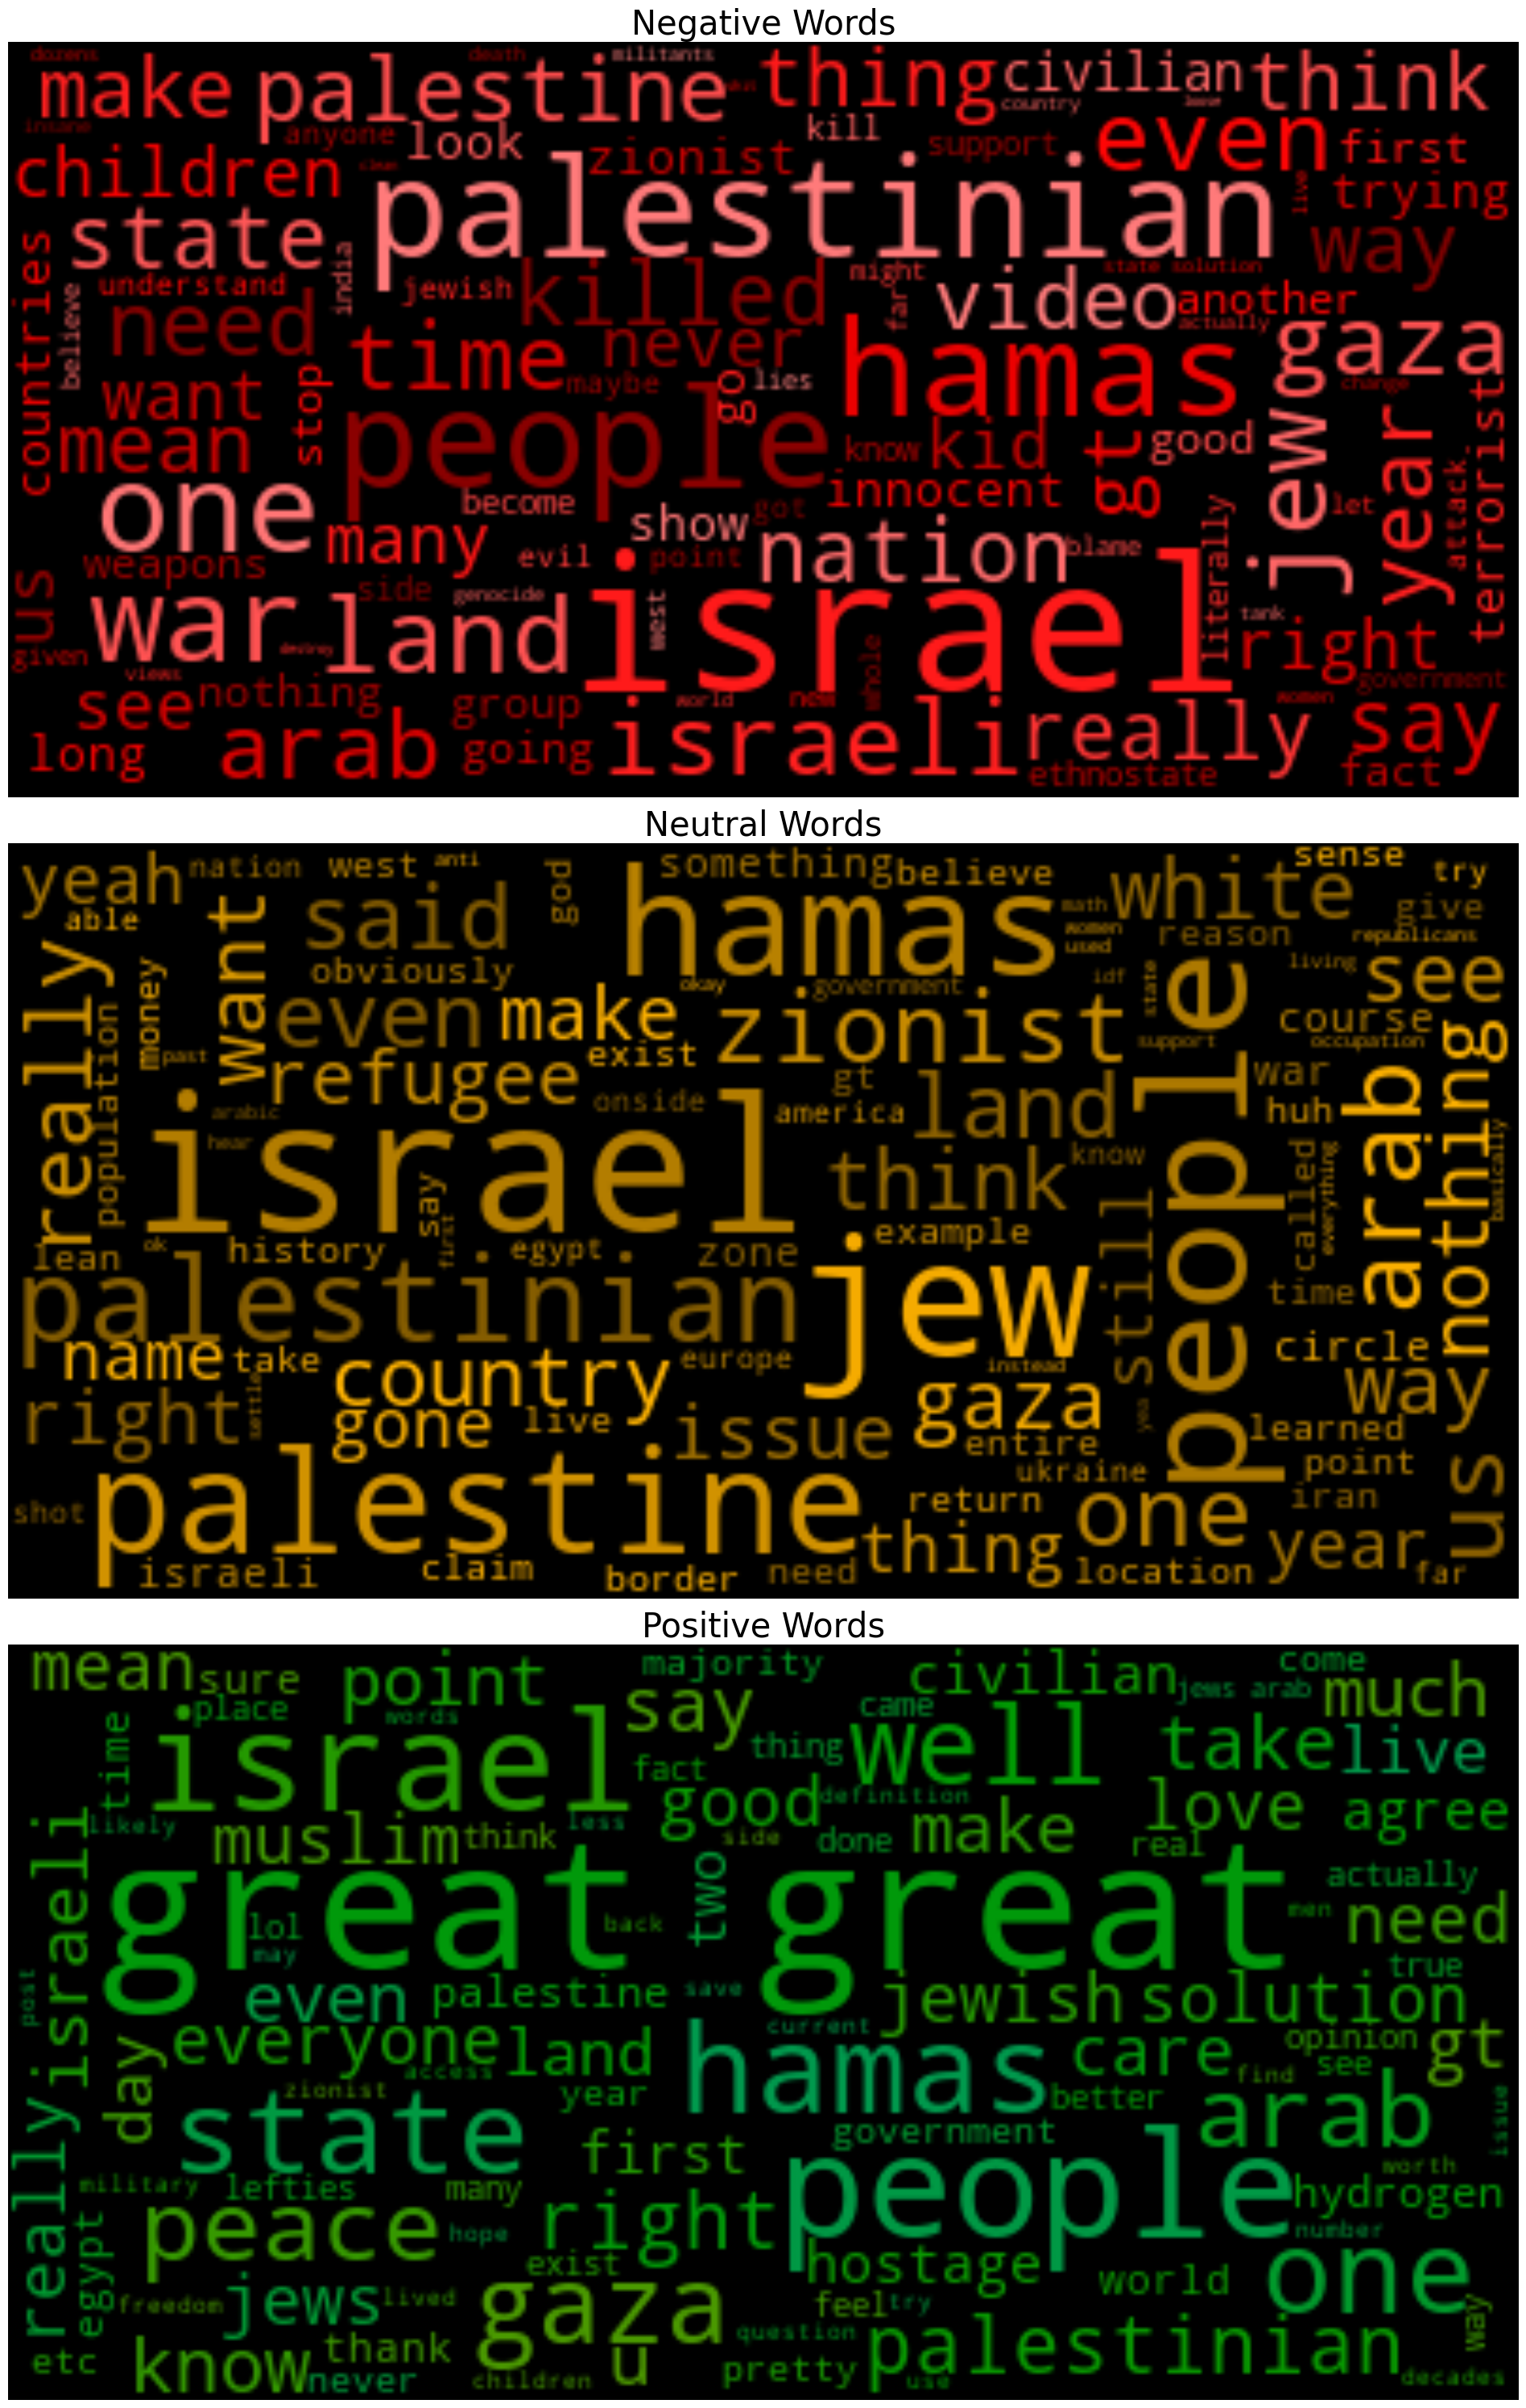

In [58]:
def flatten_list(l):
    return [x for y in l for x in y]

def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)"

def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)"

def yellow_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)"

def generate_word_clouds(neg_doc, neu_doc, pos_doc):
    # Display the generated image:
    fig, axes = plt.subplots(3, 1, figsize=(20, 30))

    wordcloud_neg = WordCloud(
        max_font_size=50, max_words=100, background_color="black"
    ).generate(" ".join(neg_doc))
    axes[0].imshow(
        wordcloud_neg.recolor(color_func=red_color_func, random_state=3),
        interpolation="bilinear",
    )
    axes[0].set_title("Negative Words", fontsize=30)
    axes[0].axis("off")

    wordcloud_neu = WordCloud(
        max_font_size=50, max_words=100, background_color="black"
    ).generate(" ".join(neu_doc))
    axes[1].imshow(
        wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3),
        interpolation="bilinear",
    )
    axes[1].set_title("Neutral Words", fontsize=30)
    axes[1].axis("off")

    wordcloud_pos = WordCloud(
        max_font_size=50, max_words=100, background_color="black"
    ).generate(" ".join(pos_doc))
    axes[2].imshow(
        wordcloud_pos.recolor(color_func=green_color_func, random_state=3),
        interpolation="bilinear",
    )
    axes[2].set_title("Positive Words", fontsize=30)
    axes[2].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(wspace=1.5)
    plt.show()

sentiment_sorted = data.sort_values("hour", ascending=False)
positive_top_100 = sentiment_sorted[
    sentiment_sorted["overall_sentiment"] == "positive"
].iloc[:100]
negative_top_100 = sentiment_sorted[
    sentiment_sorted["overall_sentiment"] == "negative"
].iloc[:100]
neutral_top_100 = sentiment_sorted[
    sentiment_sorted["overall_sentiment"] == "neutral"
].iloc[:100]

cleanup = lambda x: [
    y for y in x.split() if y not in stopwords.words("english")
]
neg_doc = flatten_list(negative_top_100["text"].apply(cleanup))
pos_doc = flatten_list(positive_top_100["text"].apply(cleanup))
neu_doc = flatten_list(neutral_top_100["text"].apply(cleanup))

generate_word_clouds(neg_doc, neu_doc, pos_doc)